In [1]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from keras.layers import *
from keras.losses import *
from keras.models import *
from keras.metrics import *
from keras.optimizers import *
from keras.applications import *
from tensorflow.keras.preprocessing.image import load_img
from keras import layers
from keras import Sequential

import tensorflow_addons as tfa
from keras.applications import MobileNetV3Large
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from keras.layers import Concatenate
from keras.models import Model
from keras.applications import Xception
import tensorflow as tf 
from joblib import Parallel, delayed
import joblib
from focal_loss import SparseCategoricalFocalLoss

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

2022-11-25 00:21:29.443213: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 00:21:30.025124: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-25 00:21:31.546641: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-25 00:21:31.546932: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

# <b>1 <span style='color:#4285f4'>|</span> Loading the Images</b>

In [2]:
train_dir = r'../Datasets/FSBr/Training/'
test_dir = '../Datasets/FSBr/Testing/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+"//" +label):
        train_paths.append(train_dir + '//'+label+ '//'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels, random_state=0)

In [3]:
[len(os.listdir(train_dir+"//" +label)) for label in os.listdir(train_dir)], os.listdir(train_dir)

([310, 1600, 1150, 780], ['pituitary', 'notumor', 'meningioma', 'glioma'])

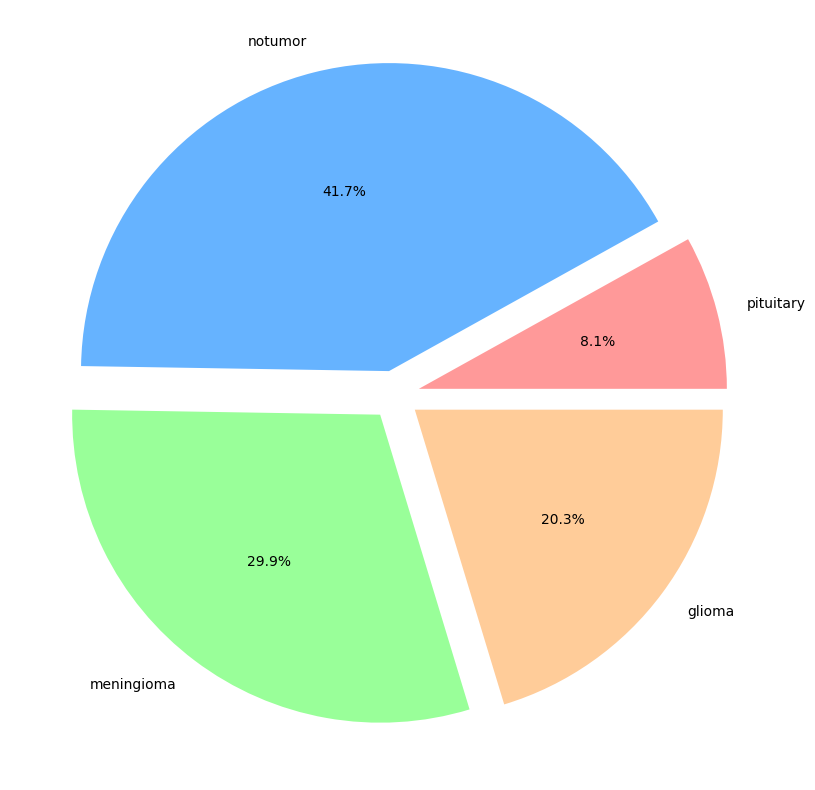

/home/raza.imam/.conda/envs/ai701/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


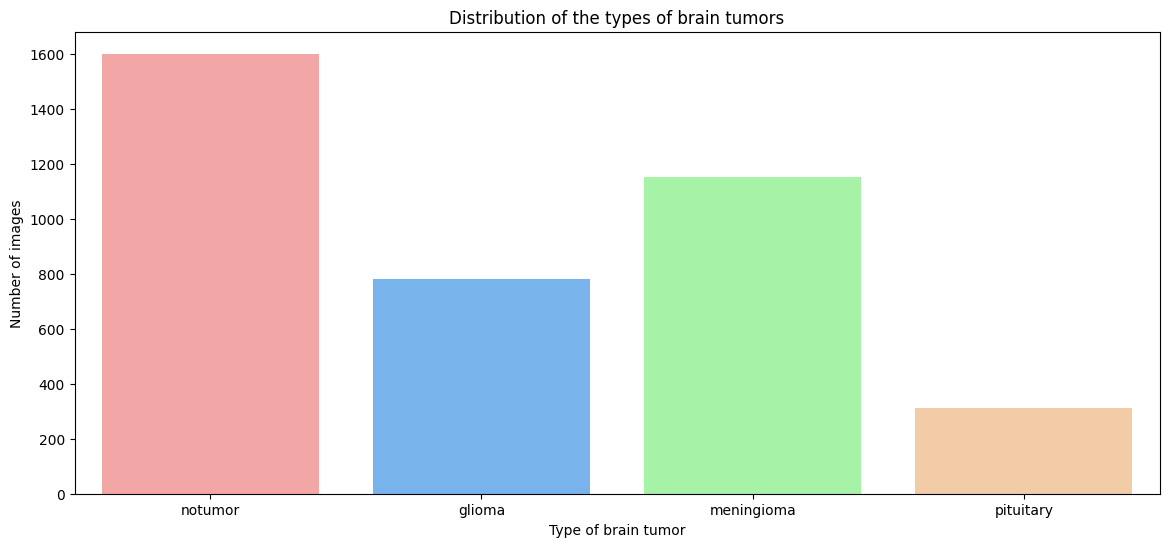

In [4]:
plt.figure(figsize=(10,10))
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie([len(os.listdir(train_dir+"//" +label)) 
        for label in os.listdir(train_dir)],
         labels=os.listdir(train_dir),
          colors = colors,
           explode = (0.08,0.08,0.08,0.08) 
           ,autopct='%1.1f%%')
plt.show()

plt.figure(figsize=(14,6))
sns.countplot(train_labels, palette=colors)
plt.title('Distribution of the types of brain tumors')
plt.xlabel('Type of brain tumor')
plt.ylabel('Number of images');

In [5]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+ '//' + label):
        test_paths.append(test_dir +'//'+label + '//'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

In [6]:
[len(os.listdir(test_dir+"//" +label)) for label in os.listdir(test_dir)], os.listdir(test_dir)

([31, 78, 160, 115], ['pituitary', 'glioma', 'notumor', 'meningioma'])

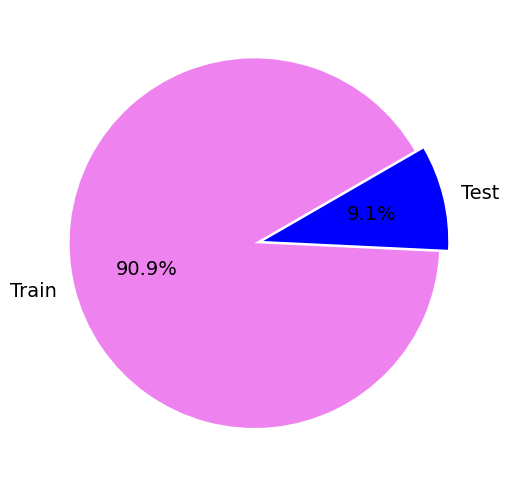

In [7]:
plt.figure(figsize=(14,6))
colors = ['Violet' , 'Blue']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

# <b>2 <span style='color:#4285f4'>|</span> Data Augmentation</b>
- Random Brightness: 80% - 120%  
- Random Contrast: 80% - 120%
- Random sharpness: 80% - 120%

In [8]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2)) #80-120% random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Sharpness(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

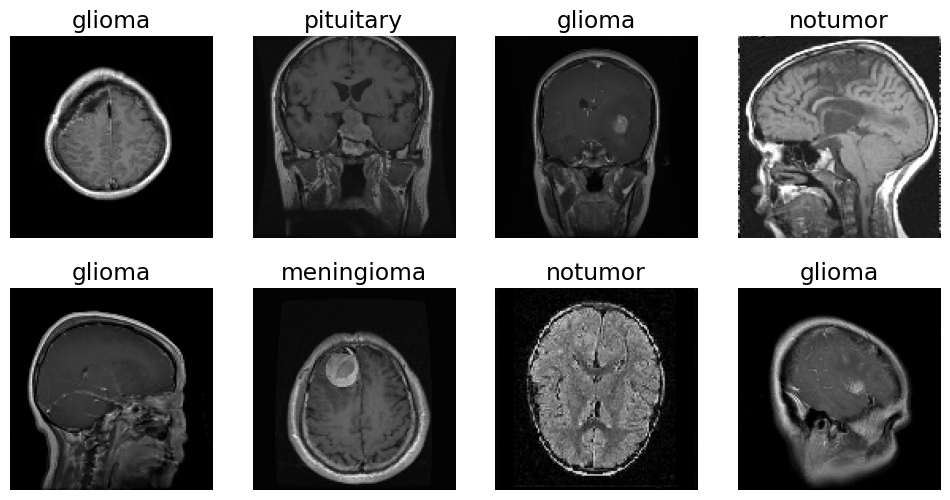

In [9]:
IMAGE_SIZE = 128

def open_images(paths):

    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)


images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()


# <b>3 <span style='color:#4285f4'>|</span> Data Generator</b>
<p style="font-size:15px; font-family:Sans; line-height: 1.7em">
    Given a list of paths to images, and the labels, <br>
    this function augments the images, normalizes them, encodes the label, and then returns the batch on which the model can train on. <br>
</p>

In [10]:
unique_labels = os.listdir(train_dir)

def encode_label(labels): #['glioma', 'meningioma', 'notumor', 'pituitary'] -> [0, 1, 2, 3]
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels): #[0, 1, 2, 3] -> ['glioma', 'meningioma', 'notumor', 'pituitary']
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

# <b><span style='color:red'>* | Misc Functions </span> </b>

In [11]:
def evaluate_model_cnn(model):
    train_loss, train_acc = model.evaluate(open_images(train_paths), encode_label(train_labels))
    test_loss, test_acc = model.evaluate(open_images(test_paths), encode_label(test_labels))
    print('Train accuracy:', train_acc)
    print('Test accuracy:', test_acc)

def print_classification_report(model):
    predictions = model.predict(open_images(test_paths))
    predictions = np.argmax(predictions, axis=1)
    print(classification_report(encode_label(test_labels), predictions, target_names=unique_labels))

def acc_vs_loss(history, epochs):
    plt.figure(figsize=(8,4))
    plt.grid(True)
    plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
    plt.plot(history.history['loss'], '.r-', linewidth=2)
    plt.title('Model Training History')
    plt.xlabel('epoch')
    plt.xticks([x for x in range(epochs)])
    plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

def evlauate_model_transfer(model):
    batch_size = 32
    steps = int(len(test_paths)/batch_size)
    y_pred = []
    y_true = []
    for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
        pred = model.predict(x)
        pred = np.argmax(pred, axis=-1)
        for i in decode_label(pred):
            y_pred.append(i)
        for i in decode_label(y):
            y_true.append(i)
    return y_true, y_pred 

# <b>4 <span style='color:#4285f4'>|</span> Modeling </b>

## <b>4.1 <span style='color:yellow'>|</span> CNN Basic </b>

In [32]:
def cnn_basic():
    # Sequential API automatically recognizes the input shape. We don’t have to specify a separate input layer.
    model = Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(16, activation='relu'),
        layers.Dense(4, activation='softmax')
        ])
    return model

cnn_model = cnn_basic()
#COMPILE
cnn_model.compile(optimizer='adam', loss=SparseCategoricalFocalLoss(gamma=3), metrics=['accuracy'])
print(cnn_model.summary())
keras.utils.plot_model(cnn_model, show_shapes=True)
#FIT
cnn_model_hist = cnn_model.fit(datagen(train_paths, train_labels, batch_size=32, epochs=10), steps_per_epoch=len(train_paths)//32, epochs=10)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (None, 28, 28, 32)        18464     
                                                                 
 flatten_1 (Flatten)         (None, 25088)            

In [33]:
joblib.dump(cnn_model, 'focal_cnn_model.pkl')
cnn_model = joblib.load('focal_cnn_model.pkl')
# cnn_model.predict(X_test)

INFO:tensorflow:Assets written to: ram://63a73f4f-fb49-42a2-ad12-fcd19bb7d345/assets


INFO:tensorflow:Assets written to: ram://63a73f4f-fb49-42a2-ad12-fcd19bb7d345/assets


In [34]:
evaluate_model_cnn(cnn_model)
print_classification_report(cnn_model)

12/12 [==============================] - 1s 63ms/step - loss: 0.2242 - accuracy: 0.7865
Train accuracy: 0.9877604246139526
Test accuracy: 0.7864583134651184
12/12 [==============================] - 1s 58ms/step
              precision    recall  f1-score   support

   pituitary       0.88      0.45      0.60        31
     notumor       0.99      0.98      0.98       160
  meningioma       0.68      0.81      0.74       115
      glioma       0.61      0.56      0.59        78

    accuracy                           0.80       384
   macro avg       0.79      0.70      0.73       384
weighted avg       0.81      0.80      0.80       384



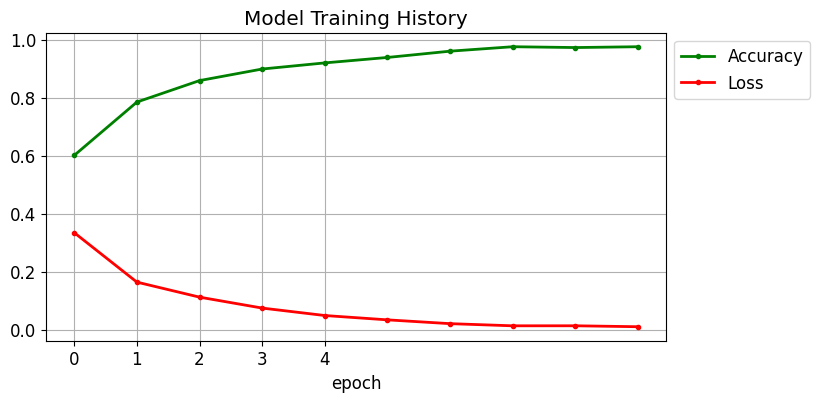

In [35]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(cnn_model_hist.history['accuracy'], '.g-', linewidth=2)
plt.plot(cnn_model_hist.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(5)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


## <b>4.2 <span style='color:yellow'>|</span> VGG16 </b>

In [36]:
def vgg16():
    base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
    # Set all layers to non-trainable
    for layer in base_model.layers:
        layer.trainable = False
    # Set the last vgg block to trainable
    base_model.layers[-2].trainable = True
    base_model.layers[-3].trainable = True
    base_model.layers[-4].trainable = True

    model = Sequential()
    model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
    model.add(base_model)
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(len(unique_labels), activation='softmax'))
    return model

vgg16_model = vgg16()
#COMPILE
vgg16_model.compile(optimizer=Adam(learning_rate=0.0001), loss=SparseCategoricalFocalLoss(gamma=3), metrics=['sparse_categorical_accuracy'])
print(vgg16_model.summary())
keras.utils.plot_model(vgg16_model, show_shapes=True)
#FIT
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 5
vgg16_model_hist = vgg16_model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_7 (Dropout)         (None, 8192)              0         
                                                                 
 dense_9 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
N

In [37]:
joblib.dump(vgg16_model, 'focal_vgg16_model.pkl')
vgg16_model = joblib.load('focal_vgg16_model.pkl')

INFO:tensorflow:Assets written to: ram://22b872a5-3272-42f8-9e3c-57a7dec7081c/assets


INFO:tensorflow:Assets written to: ram://22b872a5-3272-42f8-9e3c-57a7dec7081c/assets


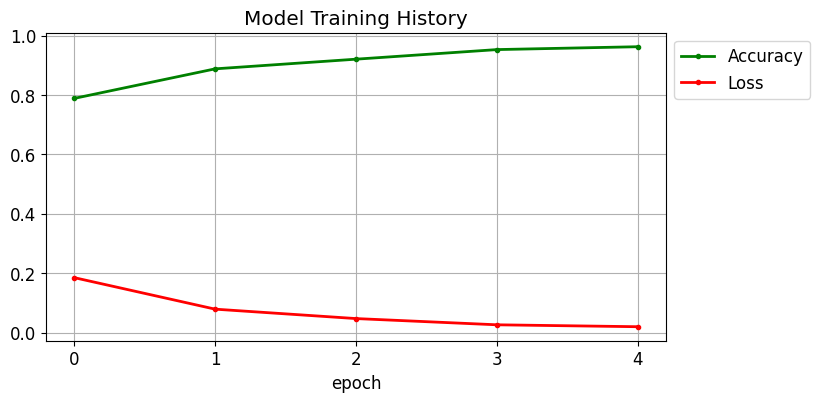

  0%|                                                                                                                                                                             | 0/12 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  8%|█████████████▊                                                                                                                                                       | 1/12 [00:01<00:17,  1.59s/it]

1/1 [==============================] - 1s 1s/step


 17%|███████████████████████████▌                                                                                                                                         | 2/12 [00:02<00:14,  1.44s/it]

1/1 [==============================] - 1s 1s/step


 25%|█████████████████████████████████████████▎                                                                                                                           | 3/12 [00:04<00:13,  1.45s/it]

1/1 [==============================] - 1s 1s/step


 33%|███████████████████████████████████████████████████████                                                                                                              | 4/12 [00:05<00:11,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 42%|████████████████████████████████████████████████████████████████████▊                                                                                                | 5/12 [00:07<00:09,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6/12 [00:08<00:08,  1.40s/it]

1/1 [==============================] - 1s 1s/step


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 7/12 [00:09<00:06,  1.38s/it]

1/1 [==============================] - 1s 1s/step


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 8/12 [00:11<00:05,  1.34s/it]

1/1 [==============================] - 1s 1s/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 9/12 [00:12<00:04,  1.36s/it]

1/1 [==============================] - 1s 1s/step


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 10/12 [00:13<00:02,  1.38s/it]

1/1 [==============================] - 1s 1s/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 11/12 [00:15<00:01,  1.35s/it]

1/1 [==============================] - 1s 1s/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:16<00:00,  1.38s/it]

              precision    recall  f1-score   support

      glioma       0.88      0.37      0.52        78
  meningioma       0.68      0.98      0.81       115
     notumor       1.00      0.98      0.99       160
   pituitary       0.93      0.87      0.90        31

    accuracy                           0.85       384
   macro avg       0.87      0.80      0.81       384
weighted avg       0.88      0.85      0.83       384



In [38]:
acc_vs_loss(vgg16_model_hist, epochs)
y_true, y_pred = evlauate_model_transfer(vgg16_model)
print(classification_report(y_true, y_pred))

## <b>4.3 <span style='color:yellow'>|</span> EfficientNetB0 </b>

In [31]:
def effB0():
    base_model = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))
    model = base_model.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)
    model = tf.keras.layers.Dropout(rate=0.5)(model)
    model = tf.keras.layers.Dense(4,activation='softmax')(model)
    model = tf.keras.models.Model(inputs=base_model.input, outputs = model)
    return model

efficientnet_model = effB0()
#COMPILE
efficientnet_model.compile(optimizer=Adam(), loss=SparseCategoricalFocalLoss(gamma=3), metrics=['sparse_categorical_accuracy'])
print(efficientnet_model.summary())
keras.utils.plot_model(efficientnet_model, show_shapes=True)
#FIT
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 5
efficientnet_model_hist = efficientnet_model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_7 (Rescaling)        (None, 128, 128, 3)  0           ['input_9[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 128, 128, 3)  7          ['rescaling_7[0][0]']            
 )                                                                                                
                                                                                            

In [16]:
# joblib.dump(efficientnet_model, 'focal_efficientnet_model.pkl')
# efficientnet_model = joblib.load('focal_efficientnet_model.pkl')

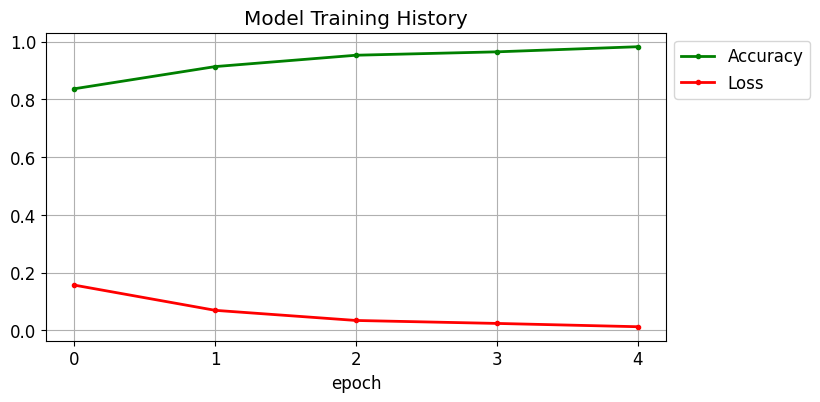

  0%|                                                                                                                                                                             | 0/12 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  8%|█████████████▊                                                                                                                                                       | 1/12 [00:01<00:17,  1.58s/it]

1/1 [==============================] - 0s 357ms/step


 17%|███████████████████████████▌                                                                                                                                         | 2/12 [00:02<00:09,  1.05it/s]

1/1 [==============================] - 0s 358ms/step


 25%|█████████████████████████████████████████▎                                                                                                                           | 3/12 [00:02<00:06,  1.33it/s]

1/1 [==============================] - 0s 379ms/step


 33%|███████████████████████████████████████████████████████                                                                                                              | 4/12 [00:03<00:05,  1.50it/s]

1/1 [==============================] - 0s 368ms/step


 42%|████████████████████████████████████████████████████████████████████▊                                                                                                | 5/12 [00:03<00:04,  1.63it/s]

1/1 [==============================] - 0s 290ms/step


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6/12 [00:04<00:03,  1.80it/s]

1/1 [==============================] - 0s 388ms/step


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 7/12 [00:04<00:02,  1.83it/s]

1/1 [==============================] - 0s 383ms/step


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 8/12 [00:05<00:02,  1.86it/s]

1/1 [==============================] - 0s 289ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 9/12 [00:05<00:01,  1.96it/s]

1/1 [==============================] - 0s 369ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 10/12 [00:06<00:01,  1.97it/s]

1/1 [==============================] - 0s 292ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 11/12 [00:06<00:00,  2.05it/s]

1/1 [==============================] - 0s 380ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:07<00:00,  1.70it/s]

              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00        78
  meningioma       0.00      0.00      0.00       115
     notumor       0.42      1.00      0.59       160
   pituitary       0.00      0.00      0.00        31

    accuracy                           0.42       384
   macro avg       0.10      0.25      0.15       384
weighted avg       0.17      0.42      0.25       384




/home/raza.imam/.conda/envs/ai701/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/raza.imam/.conda/envs/ai701/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/raza.imam/.conda/envs/ai701/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

In [33]:
acc_vs_loss(efficientnet_model_hist, epochs)
y_true, y_pred = evlauate_model_transfer(efficientnet_model)
print(classification_report(y_true, y_pred))

## <b>4.3.1 <span style='color:yellow'>|</span> EfficientNetB3 </b>

In [30]:
from keras.applications import EfficientNetB2,EfficientNetB3,EfficientNetB5,InceptionResNetV2#,EfficientNetV2S
def effb3():
    EfficientNet=EfficientNetB3(weights='imagenet', include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))
    model = EfficientNet.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)
    model = tf.keras.layers.Dropout(rate=0.55)(model)
    model = tf.keras.layers.Dense(60,activation='elu',kernel_initializer='GlorotNormal')(model)
    model = tf.keras.layers.Dropout(rate=0.3)(model)
    model = tf.keras.layers.Dense(4,activation='softmax')(model)
    model = tf.keras.models.Model(inputs=EfficientNet.input, outputs = model)
    return model

effnetB3_model = effb3()
#COMPILE
effnetB3_model.compile(optimizer=Adam(learning_rate=0.000016, beta_1=0.91, beta_2=0.9994,epsilon=1e-08), loss=SparseCategoricalFocalLoss(gamma=3), metrics=['sparse_categorical_accuracy'])
print(effnetB3_model.summary())
keras.utils.plot_model(effnetB3_model, show_shapes=True)
#FIT
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 5
effnetB3_model_model_hist = effnetB3_model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

#Try these as well
# early_stopping_cb=keras.callbacks.EarlyStopping(patience=9,restore_best_weights=True)
# history=model.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=90,
#     batch_size=13,callbacks=early_stopping_cb)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 128, 128, 3)  0           ['input_8[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 128, 128, 3)  7          ['rescaling_5[0][0]']            
 )                                                                                                
                                                                                            

In [15]:
# joblib.dump(effnetB3_model, 'focal_effnetB3_model.pkl')
# effnetB3_model = joblib.load('focal_effnetB3_model.pkl')

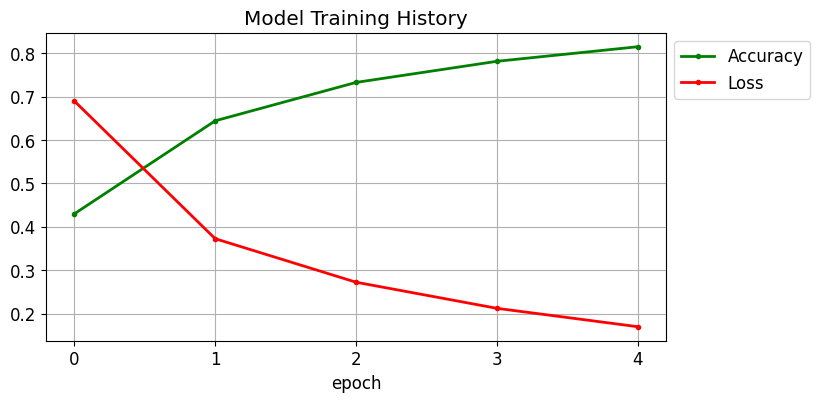

  0%|                                                                                                                                                                             | 0/12 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


  8%|█████████████▊                                                                                                                                                       | 1/12 [00:03<00:37,  3.37s/it]

1/1 [==============================] - 1s 652ms/step


 17%|███████████████████████████▌                                                                                                                                         | 2/12 [00:04<00:18,  1.85s/it]

1/1 [==============================] - 1s 572ms/step


 25%|█████████████████████████████████████████▎                                                                                                                           | 3/12 [00:04<00:12,  1.34s/it]

1/1 [==============================] - 1s 657ms/step


 33%|███████████████████████████████████████████████████████                                                                                                              | 4/12 [00:05<00:08,  1.12s/it]

1/1 [==============================] - 1s 661ms/step


 42%|████████████████████████████████████████████████████████████████████▊                                                                                                | 5/12 [00:06<00:07,  1.02s/it]

1/1 [==============================] - 1s 673ms/step


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6/12 [00:07<00:05,  1.05it/s]

1/1 [==============================] - 1s 664ms/step


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 7/12 [00:08<00:04,  1.11it/s]

1/1 [==============================] - 1s 668ms/step


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 8/12 [00:08<00:03,  1.14it/s]

1/1 [==============================] - 1s 577ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 9/12 [00:09<00:02,  1.21it/s]

1/1 [==============================] - 1s 576ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 10/12 [00:10<00:01,  1.26it/s]

1/1 [==============================] - 1s 555ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 11/12 [00:11<00:00,  1.30it/s]

1/1 [==============================] - 1s 566ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:11<00:00,  1.02it/s]

              precision    recall  f1-score   support

      glioma       0.18      0.09      0.12        78
  meningioma       0.22      0.14      0.17       115
     notumor       0.37      0.62      0.46       160
   pituitary       0.00      0.00      0.00        31

    accuracy                           0.32       384
   macro avg       0.19      0.21      0.19       384
weighted avg       0.26      0.32      0.27       384




/home/raza.imam/.conda/envs/ai701/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/raza.imam/.conda/envs/ai701/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/raza.imam/.conda/envs/ai701/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

In [35]:
acc_vs_loss(effnetB3_model_model_hist, epochs)
y_true, y_pred = evlauate_model_transfer(effnetB3_model)
print(classification_report(y_true, y_pred))

## <b>4.4 <span style='color:yellow'>|</span> ResNet50 </b>

In [16]:
def resnet50():
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))
    model = base_model.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)
    model = tf.keras.layers.Dropout(rate=0.5)(model)
    model = tf.keras.layers.Dense(4,activation='softmax')(model)
    model = tf.keras.models.Model(inputs=base_model.input, outputs = model)
    return model

resnet_model = resnet50()
#COMPILE
resnet_model.compile(optimizer=Adam(), loss=SparseCategoricalFocalLoss(gamma=3), metrics=['sparse_categorical_accuracy'])
print(resnet_model.summary())
keras.utils.plot_model(resnet_model, show_shapes=True)
#FIT
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 5
resnet_model_hist = resnet_model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

In [17]:
joblib.dump(resnet_model, 'focal_resnet_model.pkl')
resnet_model = joblib.load('focal_resnet_model.pkl')

INFO:tensorflow:Assets written to: ram://c0cc7b81-0eff-4e02-adf8-fc424178ff19/assets


INFO:tensorflow:Assets written to: ram://c0cc7b81-0eff-4e02-adf8-fc424178ff19/assets


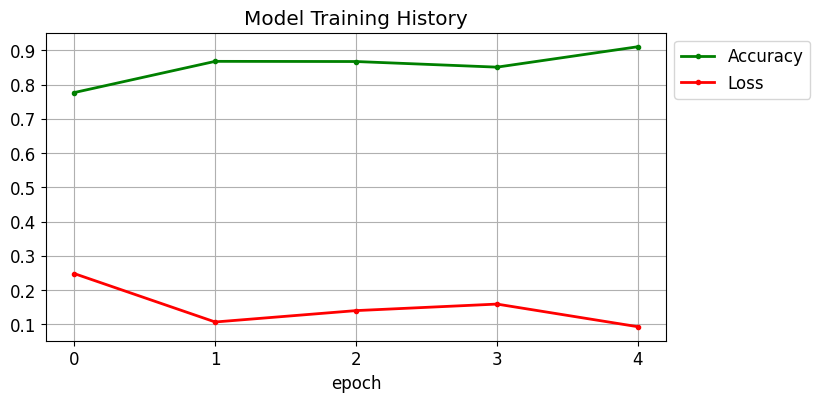

  0%|                                                                                                                                                                             | 0/12 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  8%|█████████████▊                                                                                                                                                       | 1/12 [00:01<00:17,  1.56s/it]

1/1 [==============================] - 1s 586ms/step


 17%|███████████████████████████▌                                                                                                                                         | 2/12 [00:02<00:10,  1.06s/it]

1/1 [==============================] - 1s 603ms/step


 25%|█████████████████████████████████████████▎                                                                                                                           | 3/12 [00:03<00:08,  1.09it/s]

1/1 [==============================] - 1s 600ms/step


 33%|███████████████████████████████████████████████████████                                                                                                              | 4/12 [00:03<00:06,  1.18it/s]

1/1 [==============================] - 1s 577ms/step


 42%|████████████████████████████████████████████████████████████████████▊                                                                                                | 5/12 [00:04<00:05,  1.25it/s]

1/1 [==============================] - 1s 571ms/step


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6/12 [00:05<00:04,  1.30it/s]

1/1 [==============================] - 1s 608ms/step


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 7/12 [00:05<00:03,  1.31it/s]

1/1 [==============================] - 1s 579ms/step


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 8/12 [00:06<00:03,  1.33it/s]

1/1 [==============================] - 1s 608ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 9/12 [00:07<00:02,  1.34it/s]

1/1 [==============================] - 1s 607ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 10/12 [00:08<00:01,  1.34it/s]

1/1 [==============================] - 1s 583ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 11/12 [00:08<00:00,  1.36it/s]

1/1 [==============================] - 1s 571ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:09<00:00,  1.25it/s]

              precision    recall  f1-score   support

      glioma       1.00      0.17      0.29        78
  meningioma       0.45      0.95      0.61       115
     notumor       0.97      0.59      0.73       160
   pituitary       0.69      0.71      0.70        31

    accuracy                           0.62       384
   macro avg       0.78      0.60      0.58       384
weighted avg       0.80      0.62      0.60       384



In [18]:
acc_vs_loss(resnet_model_hist, epochs)
y_true, y_pred = evlauate_model_transfer(resnet_model)
print(classification_report(y_true, y_pred))

# <b>4.5 <span style='color:#4285f4'>|</span> DenseNet121</b>

In [36]:
def densenet201():
    densenet_model=DenseNet201(weights="imagenet", include_top=False , input_shape=(IMAGE_SIZE,IMAGE_SIZE,3) )
    for layer in densenet_model.layers[:150]:
        layer.trainable=False
        x=Flatten()(densenet_model.output)
        x=Dense(1024, activation="relu")(x)
        x=Dense(1024, activation="relu")(x)
        x=Dense(512, activation="relu")(x)
        x=Dense(512, activation="relu")(x)
        x=Dense(256, activation="relu")(x)
        x=Dense(256, activation="relu")(x)
        x=Dense(128, activation="relu")(x)
        x=Dense(64, activation="relu")(x)
        output=Dense(4, activation="softmax")(x)
        model=Model(inputs=densenet_model.input, outputs=output)
        return model

densenet201_model = densenet201()
#COMPILE
densenet201_model.compile(optimizer=Adam(), loss=SparseCategoricalFocalLoss(gamma=3), metrics=['sparse_categorical_accuracy'])
print(densenet201_model.summary())
keras.utils.plot_model(densenet201_model, show_shapes=True)
#FIT
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 12
densenet201_model_hist = densenet201_model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_10[0][0]']               
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']       

In [37]:
joblib.dump(densenet201_model, 'focal_densenet201_model.pkl')
densenet201_model = joblib.load('focal_densenet201_model.pkl')

INFO:tensorflow:Assets written to: ram://74e01611-226c-40f4-9727-55eab8b3b286/assets


INFO:tensorflow:Assets written to: ram://74e01611-226c-40f4-9727-55eab8b3b286/assets


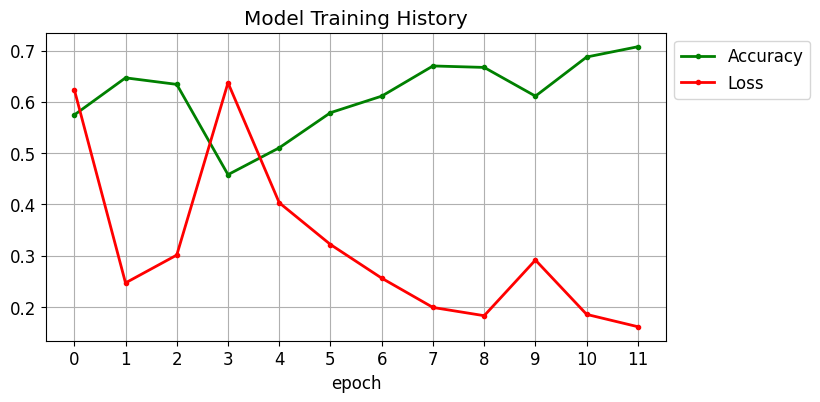

  0%|                                                                                                                                                                             | 0/12 [00:00<?, ?it/s]

1/1 [==============================] - 4s 4s/step


  8%|█████████████▊                                                                                                                                                       | 1/12 [00:04<00:47,  4.36s/it]

1/1 [==============================] - 1s 1s/step


 17%|███████████████████████████▌                                                                                                                                         | 2/12 [00:05<00:27,  2.71s/it]

1/1 [==============================] - 1s 1s/step


 25%|█████████████████████████████████████████▎                                                                                                                           | 3/12 [00:07<00:19,  2.18s/it]

1/1 [==============================] - 1s 1s/step


 33%|███████████████████████████████████████████████████████                                                                                                              | 4/12 [00:08<00:14,  1.81s/it]

1/1 [==============================] - 1s 1s/step


 42%|████████████████████████████████████████████████████████████████████▊                                                                                                | 5/12 [00:10<00:12,  1.72s/it]

1/1 [==============================] - 1s 1s/step


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6/12 [00:11<00:09,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 7/12 [00:12<00:07,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 8/12 [00:13<00:05,  1.35s/it]

1/1 [==============================] - 1s 1s/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 9/12 [00:15<00:04,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 10/12 [00:16<00:02,  1.36s/it]

1/1 [==============================] - 1s 1s/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 11/12 [00:18<00:01,  1.42s/it]

1/1 [==============================] - 1s 1s/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:19<00:00,  1.62s/it]

              precision    recall  f1-score   support

      glioma       0.24      0.15      0.19        78
  meningioma       0.50      0.68      0.58       115
     notumor       0.96      0.94      0.95       160
   pituitary       0.57      0.39      0.46        31

    accuracy                           0.66       384
   macro avg       0.57      0.54      0.54       384
weighted avg       0.64      0.66      0.64       384



In [38]:
acc_vs_loss(densenet201_model_hist, epochs)
y_true, y_pred = evlauate_model_transfer(densenet201_model)
print(classification_report(y_true, y_pred))

# <b>4.6 <span style='color:#4285f4'>|</span> MobileNet</b>

In [19]:
def mobilenet():
    base_model = MobileNetV3Large(weights='imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))
    model = base_model.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)
    model = tf.keras.layers.Dropout(rate=0.5)(model)
    model = tf.keras.layers.Dense(4,activation='softmax')(model)
    model = tf.keras.models.Model(inputs=base_model.input, outputs = model)
    return model

mobilenet_model = mobilenet()
#COMPILE
mobilenet_model.compile(optimizer=Adam(), loss=SparseCategoricalFocalLoss(gamma=3), metrics=['sparse_categorical_accuracy'])
print(mobilenet_model.summary())
keras.utils.plot_model(mobilenet_model, show_shapes=True)
#FIT
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 12
mobilenet_model_hist = mobilenet_model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 128, 128, 3)  0           ['input_4[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 64, 64, 16)   432         ['rescaling_4[0][0]']            
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 64, 64, 16)  64          ['Conv[0][0]']             

In [20]:
joblib.dump(mobilenet_model, 'focal_mobilenet_model.pkl')
mobilenet_model = joblib.load('focal_mobilenet_model.pkl')

INFO:tensorflow:Assets written to: ram://a9971066-0329-45de-bd4c-ab490eeb6b09/assets


INFO:tensorflow:Assets written to: ram://a9971066-0329-45de-bd4c-ab490eeb6b09/assets


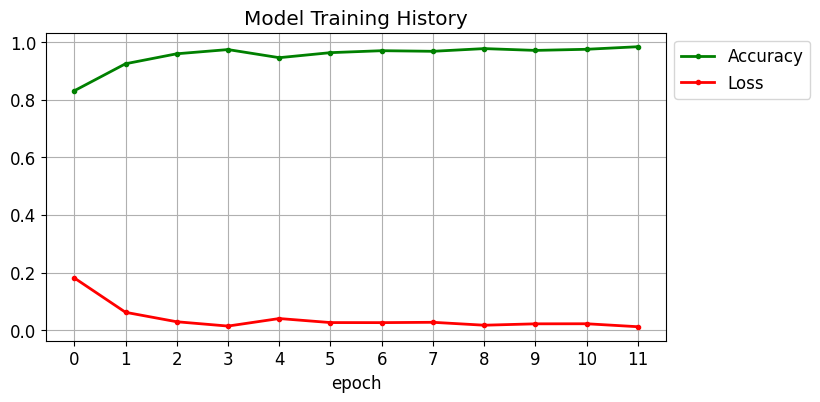

  0%|                                                                                                                                                                             | 0/12 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  8%|█████████████▊                                                                                                                                                       | 1/12 [00:01<00:13,  1.25s/it]

1/1 [==============================] - 0s 273ms/step


 17%|███████████████████████████▌                                                                                                                                         | 2/12 [00:01<00:07,  1.33it/s]

1/1 [==============================] - 0s 282ms/step


 25%|█████████████████████████████████████████▎                                                                                                                           | 3/12 [00:02<00:05,  1.65it/s]

1/1 [==============================] - 0s 270ms/step


 33%|███████████████████████████████████████████████████████                                                                                                              | 4/12 [00:02<00:04,  1.89it/s]

1/1 [==============================] - 0s 260ms/step


 42%|████████████████████████████████████████████████████████████████████▊                                                                                                | 5/12 [00:02<00:03,  2.07it/s]

1/1 [==============================] - 0s 253ms/step


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6/12 [00:03<00:02,  2.19it/s]

1/1 [==============================] - 0s 194ms/step


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 7/12 [00:03<00:02,  2.39it/s]

1/1 [==============================] - 0s 249ms/step


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 8/12 [00:04<00:01,  2.43it/s]

1/1 [==============================] - 0s 275ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 9/12 [00:04<00:01,  2.42it/s]

1/1 [==============================] - 0s 275ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 10/12 [00:04<00:00,  2.42it/s]

1/1 [==============================] - 0s 272ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 11/12 [00:05<00:00,  2.42it/s]

1/1 [==============================] - 0s 187ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.14it/s]

              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00        78
  meningioma       0.00      0.00      0.00       115
     notumor       0.42      1.00      0.59       160
   pituitary       0.00      0.00      0.00        31

    accuracy                           0.42       384
   macro avg       0.10      0.25      0.15       384
weighted avg       0.17      0.42      0.25       384




/home/raza.imam/.conda/envs/ai701/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/raza.imam/.conda/envs/ai701/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/raza.imam/.conda/envs/ai701/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

In [21]:
acc_vs_loss(mobilenet_model_hist, epochs)
y_true, y_pred = evlauate_model_transfer(mobilenet_model)
print(classification_report(y_true, y_pred))

# <b>4.7 <span style='color:#4285f4'>|</span> GoogleNet</b>

In [22]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = Concatenate(axis = -1)([path1, path2, path3, path4])

  return output_layer

def GoogLeNet():
    # input layer 
    input_layer = Input(shape = (IMAGE_SIZE,IMAGE_SIZE,3))

    # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
    X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # convolutional layer: filters = 64, strides = 1
    X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

    # convolutional layer: filters = 192, kernel_size = (3,3)
    X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 1st Inception block
    X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

    # 2nd Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 3rd Inception block
    X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

    # 4th Inception block
    X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 5th Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 6th Inception block
    X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

    # 7th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # 8th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

    # 9th Inception block
    X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

    # Global Average pooling layer 
    X = GlobalAveragePooling2D(name = 'GAPL')(X)

    # Dropoutlayer 
    X = Dropout(0.4)(X)

    # output layer 
    X = Dense(4, activation = 'softmax')(X)

    # model
    model = Model(input_layer, X, name = 'GoogLeNet')

    return model

In [23]:
googlenet_model = GoogLeNet()
#COMPILE
googlenet_model.compile(loss=SparseCategoricalFocalLoss(gamma=3), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['sparse_categorical_accuracy'])
print(googlenet_model.summary())
keras.utils.plot_model(googlenet_model, show_shapes=True)
#FIT
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 5
googlenet_model_hist = googlenet_model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 61, 61, 64)   9472        ['input_5[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 30, 30, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 30, 30, 64)   4160        ['max_pooling2d[0][0]']  

In [24]:
joblib.dump(googlenet_model, 'focal_googlenet_model.pkl')
googlenet_model = joblib.load('focal_googlenet_model.pkl')

INFO:tensorflow:Assets written to: ram://8f824c0d-01d6-47bd-936d-a1f8eeb2efaa/assets


INFO:tensorflow:Assets written to: ram://8f824c0d-01d6-47bd-936d-a1f8eeb2efaa/assets


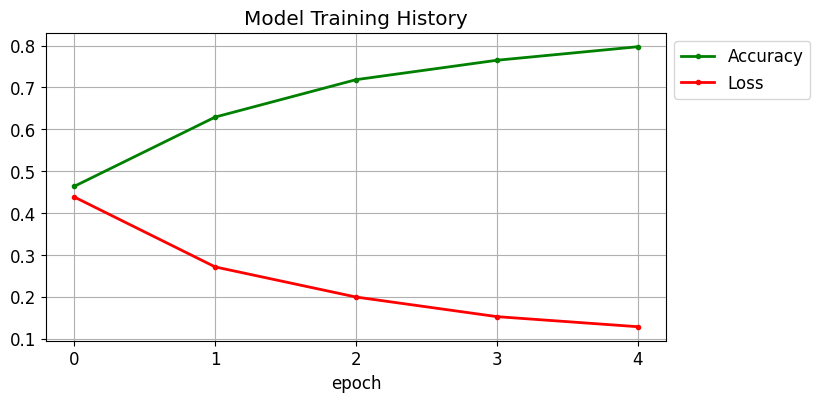

  0%|                                                                                                                                                                             | 0/12 [00:00<?, ?it/s]

1/1 [==============================] - 1s 566ms/step


  8%|█████████████▊                                                                                                                                                       | 1/12 [00:00<00:07,  1.38it/s]

1/1 [==============================] - 0s 186ms/step


 17%|███████████████████████████▌                                                                                                                                         | 2/12 [00:01<00:04,  2.04it/s]

1/1 [==============================] - 0s 177ms/step


 25%|█████████████████████████████████████████▎                                                                                                                           | 3/12 [00:01<00:03,  2.43it/s]

1/1 [==============================] - 0s 174ms/step


 33%|███████████████████████████████████████████████████████                                                                                                              | 4/12 [00:01<00:03,  2.66it/s]

1/1 [==============================] - 0s 168ms/step


 42%|████████████████████████████████████████████████████████████████████▊                                                                                                | 5/12 [00:02<00:02,  2.83it/s]

1/1 [==============================] - 0s 175ms/step


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6/12 [00:02<00:02,  2.97it/s]

1/1 [==============================] - 0s 179ms/step


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 7/12 [00:02<00:01,  3.00it/s]

1/1 [==============================] - 0s 164ms/step


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 8/12 [00:02<00:01,  3.05it/s]

1/1 [==============================] - 0s 172ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 9/12 [00:03<00:00,  3.06it/s]

1/1 [==============================] - 0s 158ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 10/12 [00:03<00:00,  3.15it/s]

1/1 [==============================] - 0s 175ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 11/12 [00:03<00:00,  3.18it/s]

1/1 [==============================] - 0s 163ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.87it/s]

              precision    recall  f1-score   support

      glioma       0.74      0.33      0.46        78
  meningioma       0.62      0.88      0.72       115
     notumor       0.97      0.97      0.97       160
   pituitary       0.73      0.61      0.67        31

    accuracy                           0.78       384
   macro avg       0.77      0.70      0.71       384
weighted avg       0.80      0.78      0.77       384



In [25]:
acc_vs_loss(googlenet_model_hist, epochs)
y_true, y_pred = evlauate_model_transfer(googlenet_model)
print(classification_report(y_true, y_pred))

# <b>4.8 <span style='color:#4285f4'>|</span> XceptionNet</b>

In [12]:
def xceptionnet():
    base_model = Xception(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
    # Set all layers to non-trainable
    for layer in base_model.layers:
        layer.trainable = False
    # Set the last vgg block to trainable
    base_model.layers[-2].trainable = True
    base_model.layers[-3].trainable = True
    base_model.layers[-4].trainable = True
    base_model.layers[-5].trainable = True
    model = Sequential()
    model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
    model.add(base_model)
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(len(unique_labels), activation='softmax'))
    return model

In [13]:
xception_model = xceptionnet()
#COMPILE
xception_model.compile(loss=SparseCategoricalFocalLoss(gamma=3), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['sparse_categorical_accuracy'])
print(xception_model.summary())
keras.utils.plot_model(xception_model, show_shapes=True)
#FIT
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 5
xception_model_hist = xception_model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

2022-11-25 00:25:58.300088: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-11-25 00:25:58.302203: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-11-25 00:25:58.302286: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-25 00:25:58.303140: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0

In [28]:
joblib.dump(xception_model, 'focal_xception_model.pkl')
xception_model = joblib.load('focal_xception_model.pkl')

INFO:tensorflow:Assets written to: ram://9f4e9a52-2d76-4f53-96c6-6277192688ed/assets


INFO:tensorflow:Assets written to: ram://9f4e9a52-2d76-4f53-96c6-6277192688ed/assets


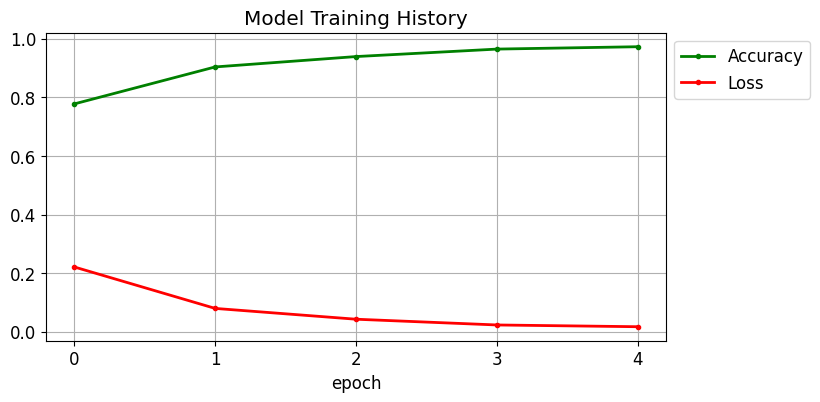

  0%|                                                                                                                                                                             | 0/12 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  8%|█████████████▊                                                                                                                                                       | 1/12 [00:02<00:25,  2.28s/it]

1/1 [==============================] - 1s 739ms/step


 17%|███████████████████████████▌                                                                                                                                         | 2/12 [00:03<00:14,  1.49s/it]

1/1 [==============================] - 1s 713ms/step


 25%|█████████████████████████████████████████▎                                                                                                                           | 3/12 [00:04<00:10,  1.20s/it]

1/1 [==============================] - 1s 681ms/step


 33%|███████████████████████████████████████████████████████                                                                                                              | 4/12 [00:05<00:08,  1.12s/it]

1/1 [==============================] - 1s 890ms/step


 42%|████████████████████████████████████████████████████████████████████▊                                                                                                | 5/12 [00:06<00:07,  1.13s/it]

1/1 [==============================] - 1s 700ms/step


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6/12 [00:07<00:06,  1.05s/it]

1/1 [==============================] - 1s 684ms/step


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 7/12 [00:08<00:05,  1.02s/it]

1/1 [==============================] - 1s 679ms/step


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 8/12 [00:08<00:03,  1.02it/s]

1/1 [==============================] - 1s 654ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 9/12 [00:09<00:02,  1.03it/s]

1/1 [==============================] - 1s 894ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 10/12 [00:11<00:02,  1.16s/it]

1/1 [==============================] - 1s 877ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 11/12 [00:12<00:01,  1.15s/it]

1/1 [==============================] - 1s 765ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:13<00:00,  1.13s/it]

              precision    recall  f1-score   support

      glioma       0.84      0.33      0.48        78
  meningioma       0.62      0.92      0.74       115
     notumor       1.00      1.00      1.00       160
   pituitary       0.83      0.61      0.70        31

    accuracy                           0.81       384
   macro avg       0.82      0.72      0.73       384
weighted avg       0.84      0.81      0.79       384



In [14]:
acc_vs_loss(xception_model_hist, epochs)
y_true, y_pred = evlauate_model_transfer(xception_model)
print(classification_report(y_true, y_pred))

# <b>4.8 <span style='color:#4285f4'>|</span> Transformers</b>

# <b>4.9 <span style='color:#4285f4'>|</span> NASnet</b>

# <b>4.10 <span style='color:#4285f4'>|</span> XGBoost</b>